# Mapping each sample on the atlas

In [1]:
# Load packages
suppressPackageStartupMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(SingleCellExperiment)
    library(scater)
    library(scran)
    library(edgeR)
    library(ggrastr)
    library(batchelor)
})

here::i_am("mapping/run/01_mapping_manual.ipynb")

# Load mapping functions
source(here::here("mapping/run/mnn/mapping_functions_extended.R"))

# Load default settings
source(here::here("settings.R"))
source(here::here("utils.R"))

set.seed(1234)

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/12_Eomes_T_Mixl1/T/code



In [7]:
args = list()
args$atlas_sce = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation/pijuansala2019_gastrulation10x/processed/SingleCellExperiment.rds'
args$atlas_metadata = '/rds/project/rds-SDzz0CATGms/users/bt392/atlasses/gastrulation/pijuansala2019_gastrulation10x/sample_metadata_extended.txt.gz'
args$atlas_stages = c('E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5')
args$npcs = 40
args$n_neighbours = 15
args$cosine_normalisation = FALSE

args$sce = io$rna.sce
args$metadata =  paste0(io$basedir,"results/rna/doublet_detection/sample_metadata_after_doublets.txt.gz")
args$outdir = paste0(io$basedir,"/results/rna/mapping/manual/")
dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

In [8]:
################
## Load query ##
################

# Get query data
meta_query = fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_score <= 0.5] # Resetting doublet score threshold
# Load RNA expression data as SingleCellExperiment object
sce_query <- load_SingleCellExperiment(args$sce, cells=meta_query$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce_query) <- meta_query %>% tibble::column_to_rownames("cell") %>% DataFrame

In [11]:
################
## Load atlas ##
################

# Load cell metadata
meta_atlas <- fread(args$atlas_metadata) %>%
  .[stage%in%args$atlas_stages] %>%
  .[,sample:=factor(sample)] 

# Filter
if (isTRUE(args$test)) meta_atlas <- head(meta_atlas,n=1000)

# Load SingleCellExperiment
sce_atlas <- load_SingleCellExperiment(args$atlas_sce, normalise = TRUE, cells = meta_atlas$cell, remove_non_expressed_genes = TRUE)

# Update colData
tmp <- meta_atlas %>% .[cell%in%colnames(sce_atlas)] %>% setkey(cell) %>% .[colnames(sce_atlas)]
stopifnot(tmp$cell == colnames(sce_atlas))
colData(sce_atlas) <- tmp %>% as.data.frame %>% tibble::column_to_rownames("cell") %>%
  .[colnames(sce_atlas),] %>% DataFrame()

# Sanity cehcks
stopifnot(sum(is.na(rownames(sce_atlas)))==0)
stopifnot(sum(duplicated(rownames(sce_atlas)))==0)

In [12]:
#####################
## Define gene set ##
#####################

# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol")] %>%
  .[symbol!="" & ens_id%in%rownames(sce_atlas)] %>%
  .[!duplicated(symbol)]

rownames(sce_atlas) = gene_metadata[match(rownames(sce_atlas), ens_id), symbol]

In [14]:
# Imprinted genes
# imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
#                        grep('paternally', gene_metadata$description)), symbol]
#Other imprinted genes: 
#- Nnat (https://www.genecards.org/cgi-bin/carddisp.pl?gene=NNAT)
#- Grb10 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRB10)

# Intersect genes
genes.intersect <- intersect(rownames(sce_query), rownames(sce_atlas))

# Filter some genes manually
genes.intersect <- genes.intersect[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes.intersect,invert=T)] # filter out non-informative genes
genes.intersect <- genes.intersect[grep("^Hbb|^Hba",genes.intersect,invert=T)] # test removing Haem genes 
genes.intersect <- genes.intersect[!genes.intersect %in% c('Grb10', 'Nnat')] # remove imprinted genes
genes.intersect <- genes.intersect[!genes.intersect %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes.intersect <- genes.intersect[!genes.intersect=="tomato-td"] # remove tomato itself
genes.intersect <- genes.intersect[!genes.intersect %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

# Subset SingleCellExperiment objects
sce_query  <- sce_query[genes.intersect,]
sce_atlas <- sce_atlas[genes.intersect,]

In [15]:
#######################
## Feature selection ##
#######################

# Load gene statistics from the atlas
gene_stats.dt <- fread(paste0(io$atlas.basedir,"/results/gene_statistics/gene_statistics.txt.gz")) %>%
.[gene%in%genes.intersect]
genes_to_use <- gene_stats.dt %>% setorder(-var_pseudobulk, na.last = T) %>% head(n=4000) %>% .$gene  

stopifnot(genes_to_use%in%rownames(sce_atlas))
stopifnot(genes_to_use%in%rownames(sce_query))

sce_query = sce_query[genes_to_use,]
sce_atlas = sce_atlas[genes_to_use,]

In [16]:
sce_query
sce_atlas

class: SingleCellExperiment 
dim: 4000 25444 
metadata(0):
assays(2): counts logcounts
rownames(4000): Tdgf1 Hoxaas3 ... Ppp2r3a Upk1b
rowData names(0):
colnames(25444): sample_1#AAACCTGAGGTGCAAC sample_1#AAACCTGCAGTACACT
  ... sample_9#TTTGTCAGTTAAGATG sample_9#TTTGTCATCCTCCTAG
colData names(13): sample barcode ... doublet_score doublet_call
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

class: SingleCellExperiment 
dim: 4000 75012 
metadata(1): log.exprs.offset
assays(2): counts logcounts
rownames(4000): Tdgf1 Hoxaas3 ... Ppp2r3a Upk1b
rowData names(0):
colnames(75012): cell_361 cell_362 ... cell_139330 cell_139331
colData names(13): barcode sample ... index celltype_extended
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [17]:
mapping_full = mclapply(unique(meta_query$sample), function(x){
    mapping  <- mapWrap(
          sce_atlas = sce_atlas,
          meta_atlas = meta_atlas,
          sce_query = sce_query[,meta_query[sample==x, cell]],
          meta_query = meta_query[sample==x, ],
          genes = genes_to_use,
          npcs = args$npcs,
          k = args$n_neighbours,
          cosineNorm = args$cosine_normalisation,
          order = NULL
        )
    
    mapping.dt <- mapping$mapping %>% 
      .[,c("cell","celltype.mapped","celltype.score","celltype_extended.mapped","celltype_extended.score","stage.mapped", "cellstage.score", "closest.cell")] %>% 
      as.data.table
    
    return(mapping.dt)
}, mc.cores=4)

In [18]:
mapping_full = mapping_full %>% rbindlist()

In [19]:
mapping_full = mapping_full %>% setnames(colnames(mapping_full)[-1], paste0(colnames(mapping_full)[-1], '_mnn'))

In [20]:
meta_full = merge(meta_query, mapping_full, by='cell') %>% 
    .[match(colnames(sce_query), cell)]

In [21]:
fwrite(meta_full, file.path(args$outdir, 'sample_metadata_after_mapping.txt.gz'), sep="\t")

In [22]:
args$outdir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/12_Eomes_T_Mixl1/T//results/rna/mapping/manual/"

#### Integration over full dataset to get common embedding

In [231]:
# Full dimensionality reduction
mapping  <- mapWrap(
      sce_atlas = sce_atlas,
      meta_atlas = meta_atlas,
      sce_query = sce_query,
      meta_query = meta_query,
      genes = genes_to_use,
      npcs = args$npcs,
      k = args$n_neighbours,
      cosineNorm = args$cosine_normalisation,
      order = NULL
    )

mapping.dt <- mapping$mapping %>% 
  .[,c("cell","celltype.mapped","celltype.score","celltype_extended.mapped","celltype_extended.score","stage.mapped", "cellstage.score", "closest.cell")] %>% 
  as.data.table

Normalizing joint dataset using cosineNorm=FALSE...

Done


4000 Genes provided...

Performing PCA...

Done


Batch effect correction for the atlas...

Done


MNN mapping...

Done


Computing mapping scores...

Done


Writing output...

Done




In [232]:
PCA = rbind(mapping$pca_atlas_corrected, mapping$pca_query_corrected)

In [233]:
meta_big = rbind(meta_atlas[,c('cell', 'celltype', 'celltype_extended')] %>% .[,origin:='atlas'],
                 mapping.dt[,c('cell', 'celltype.mapped', 'celltype_extended.mapped')] %>% 
                setnames(c('cell', 'celltype', 'celltype_extended'))  %>% .[,origin:='chimera']) %>%
    .[match(rownames(PCA), cell)]

In [234]:
UMAP <- as.data.table(calculateUMAP(t(PCA), n_neighbors = 25, min_dist = 0.3)) %>%
    setnames(c('UMAP1', 'UMAP2')) %>% 
    .[,cell:=rownames(PCA)] %>% 
    merge(., meta_big, by='cell')

In [241]:
options(repr.plot.width=15, repr.plot.height=6)
p1 = ggplot(UMAP[sample(nrow(UMAP), nrow(UMAP))], aes(UMAP1, UMAP2, color=origin)) + 
    geom_point(size=0.05) + 
 #   scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='none',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

options(repr.plot.width=15, repr.plot.height=6)
p2 = ggplot(UMAP, aes(UMAP1, UMAP2, color=celltype_extended)) + 
    geom_point(size=0.5) + 
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='none',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

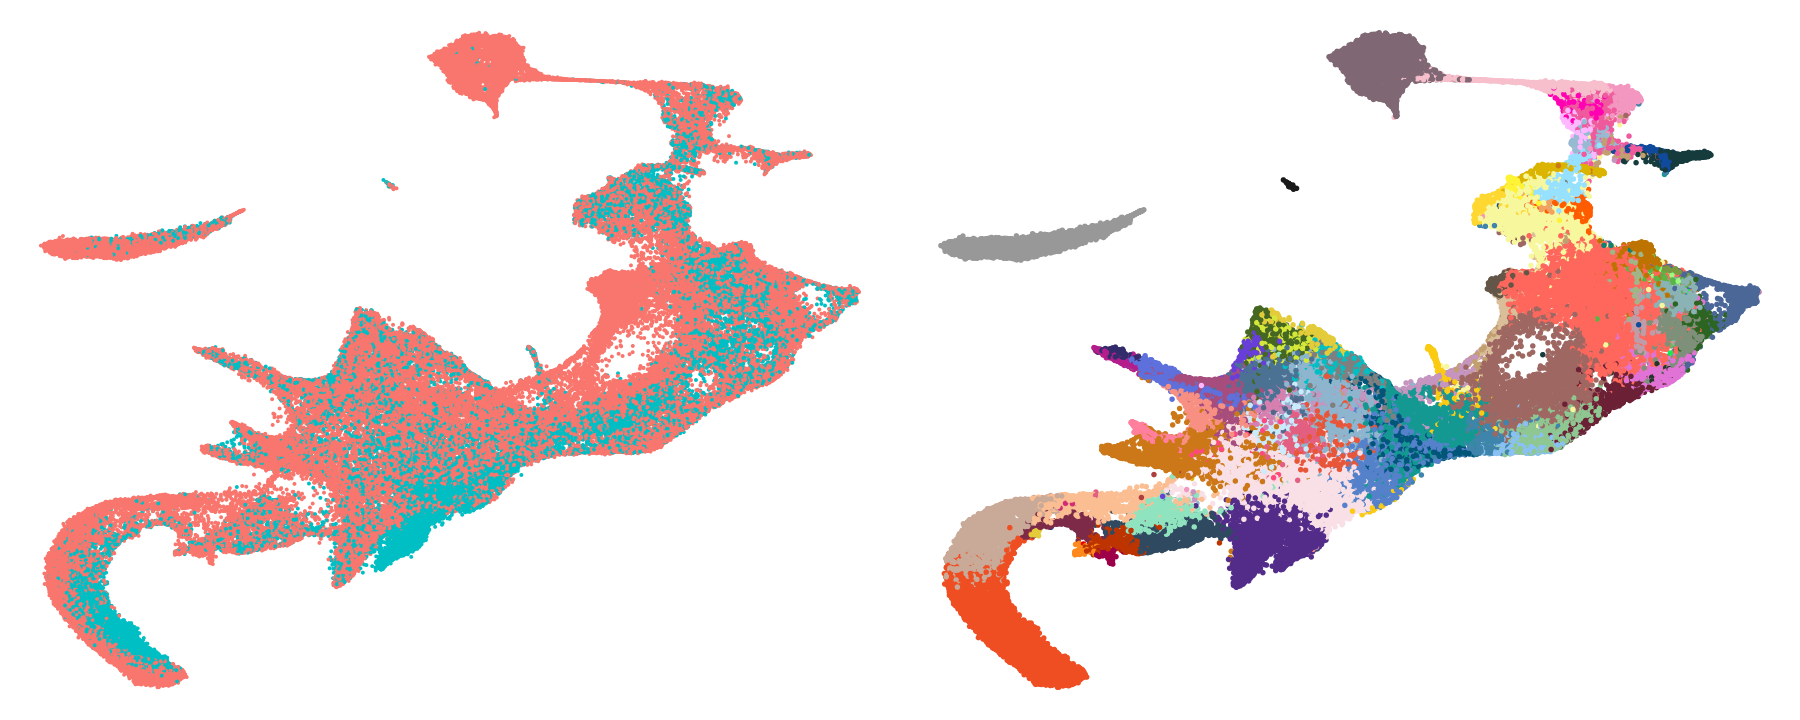

In [242]:
ggarrange(p1, p2)

# Mapping endothelium specifically

In [176]:
args$npcs = 10
args$n_neighbours = 15

In [177]:
meta_query = fread(file.path(args$outdir, 'sample_metadata_after_mapping.txt.gz'))

In [178]:
################
## Load query ##
################

# Get query data
sce_query <- load_SingleCellExperiment(args$sce, cells=meta_query$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce_query) <- meta_query %>% tibble::column_to_rownames("cell") %>% DataFrame

In [179]:
################
## Load atlas ##
################

# Load cell metadata
meta_atlas <- fread(args$atlas_metadata) %>%
  .[stage%in%args$atlas_stages] %>%
  .[,sample:=factor(sample)] 

# Load SingleCellExperiment
sce_atlas <- load_SingleCellExperiment(args$atlas_sce, normalise = TRUE, cells = meta_atlas$cell, remove_non_expressed_genes = TRUE)

# Update colData
tmp <- meta_atlas %>% .[cell%in%colnames(sce_atlas)] %>% setkey(cell) %>% .[colnames(sce_atlas)]
stopifnot(tmp$cell == colnames(sce_atlas))
colData(sce_atlas) <- tmp %>% as.data.frame %>% tibble::column_to_rownames("cell") %>%
  .[colnames(sce_atlas),] %>% DataFrame()

# Sanity cehcks
stopifnot(sum(is.na(rownames(sce_atlas)))==0)
stopifnot(sum(duplicated(rownames(sce_atlas)))==0)

In [180]:
#####################
## Define gene set ##
#####################

# Get gene metadata
gene_metadata <- fread(io$gene_metadata) %>% .[,c("chr","ens_id","symbol")] %>%
  .[symbol!="" & ens_id%in%rownames(sce_atlas)] %>%
  .[!duplicated(symbol)]

rownames(sce_atlas) = gene_metadata[match(rownames(sce_atlas), ens_id), symbol]

In [181]:
# Imprinted genes
imprint = gene_metadata[c(grep('maternally', gene_metadata$description),
                       grep('paternally', gene_metadata$description)), symbol]
#Other imprinted genes: 
#- Nnat (https://www.genecards.org/cgi-bin/carddisp.pl?gene=NNAT)
#- Grb10 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GRB10)

# Intersect genes
genes.intersect <- intersect(rownames(sce_query), rownames(sce_atlas))

# Filter some genes manually
genes.intersect <- genes.intersect[grep("^Rik|Rik$|^mt-|^Rps|^Rpl|^Gm",genes.intersect,invert=T)] # filter out non-informative genes
genes.intersect <- genes.intersect[grep("^Hbb|^Hba",genes.intersect,invert=T)] # test removing Haem genes 
genes.intersect <- genes.intersect[!genes.intersect %in% c(imprint, 'Grb10', 'Nnat')] # remove imprinted genes
genes.intersect <- genes.intersect[!genes.intersect %in% c("Xist", "Tsix")] # remove Xist & Tsix
genes.intersect <- genes.intersect[!genes.intersect=="tomato-td"] # remove tomato itself
genes.intersect <- genes.intersect[!genes.intersect %in% gene_metadata[chr=="chrY",symbol]] # no genes on y-chr 

# Subset SingleCellExperiment objects
sce_query  <- sce_query[genes.intersect,]
sce_atlas <- sce_atlas[genes.intersect,]

In [182]:
unique(sce_query$celltype_extended.mapped_mnn)

[1] "Ectoderm"                             
 [2] "Intermediate_mesoderm"                
 [3] "Allantois"                            
 [4] "Non-neural_ectoderm"                  
 [5] "Lateral_plate_mesoderm"               
 [6] "Presomitic_mesoderm"                  
 [7] "Optic_vesicle"                        
 [8] "Caudal_epiblast"                      
 [9] "Dorsal_spinal_cord_progenitors"       
[10] "Amniotic_ectoderm"                    
[11] "PGC"                                  
[12] "Ventral_hindbrain_progenitors"        
[13] "Dermomyotome"                         
[14] "Pharyngeal_endoderm"                  
[15] "NMPs"                                 
[16] "Somitic_mesoderm"                     
[17] "Midbrain_progenitors"                 
[18] "Limb_ectoderm"                        
[19] "Limb_mesoderm"                        
[20] "Caudal_mesoderm"                      
[21] "NMPs_Mesoderm-biased"                 
[22] "Paraxial_mesoderm"                    
[23] "Ventral_forebrain_progenitors"        
[24] "Pharyngeal_mesoderm"                  
[25] "Spinal_cord_progenitors"              
[26] "Midbrain_Hindbrain_boundary"          
[27] "ExE_ectoderm"                         
[28] "Epidermis"                            
[29] "Surface_ectoderm"                     
[30] "Placodal_ectoderm"                    
[31] "Cardiopharyngeal_progenitors_SHF"     
[32] "Kidney_primordium"                    
[33] "Cardiopharyngeal_progenitors_FHF"     
[34] "Posterior_somitic_tissues"            
[35] "YS_endothelium"                       
[36] "Erythroid"                            
[37] "Venous_endothelium"                   
[38] "Cardiomyocytes_FHF_1"                 
[39] "Embryo_proper_endothelium"            
[40] "Mesenchyme"                           
[41] "Allantois_endothelium"                
[42] "Anterior_somitic_tissues"             
[43] "Cranial_mesoderm"                     
[44] "EMP"                                  
[45] "Thyroid_primordium"                   
[46] "Cardiomyocytes_FHF_2"                 
[47] "Anterior_cardiopharyngeal_progenitors"
[48] "Sclerotome"                           
[49] "Hindgut"                              
[50] "Cardiomyocytes_SHF_1"                 
[51] "Hindbrain_floor_plate"                
[52] "Visceral_endoderm"                    
[53] "Haematoendothelial_progenitors"       
[54] "Blood_progenitors"                    
[55] "Gut_tube"                             
[56] "Node"                                 
[57] "YS_mesothelium"                       
[58] "MEP"                                  
[59] "Foregut"                              
[60] "Migratory_neural_crest"               
[61] "Notochord"                            
[62] "Otic_placode"                         
[63] "Dorsal_hindbrain_progenitors"         
[64] "Megakaryocyte_progenitors"            
[65] "Cardiopharyngeal_progenitors"         
[66] "Epicardium"                           
[67] "Cardiomyocytes_SHF_2"                 
[68] "Endocardium"                          
[69] "Anterior_Primitive_Streak"            
[70] "Embryo_proper_mesothelium"            
[71] "Parietal_endoderm"                    
[72] "Hindbrain_neural_progenitors"         
[73] "ExE_endoderm"                         
[74] "Midgut"                               
[75] "Late_dorsal_forebrain_progenitors"    
[76] "Nascent_mesoderm"                     
[77] "Epiblast"

In [183]:
colnames(meta_query)

[1] "cell"                         "sample"                      
 [3] "barcode"                      "nFeature_RNA"                
 [5] "nCount_RNA"                   "mitochondrial_percent_RNA"   
 [7] "ribosomal_percent_RNA"        "stage"                       
 [9] "tdTom"                        "idx"                         
[11] "tdTom_corr"                   "pass_rnaQC"                  
[13] "doublet_score"                "doublet_call"                
[15] "celltype.mapped_mnn"          "celltype.score_mnn"          
[17] "celltype_extended.mapped_mnn" "celltype_extended.score_mnn" 
[19] "stage.mapped_mnn"             "cellstage.score_mnn"         
[21] "closest.cell_mnn"

In [184]:
#################################
## Subset to endothelial cells ##
#################################

#celltypes_keep = c("Endothelium", "Haematoendothelial_progenitors")
celltypes_keep = c('YS_endothelium','Venous_endothelium','Embryo_proper_endothelium','Allantois_endothelium', 'Endocardium')
meta_query = meta_query[celltype_extended.mapped_mnn %in% celltypes_keep]
sce_query = sce_query[,meta_query$cell]
meta_atlas = meta_atlas[celltype_extended %in% celltypes_keep]
sce_atlas = sce_atlas[,meta_atlas$cell]

In [185]:
decomp <- modelGeneVar(sce_atlas, block=meta_atlas$sample)
decomp <- decomp[decomp$mean > 0.01,]
genes_to_use <- decomp[order(decomp$FDR),] %>% 
    as.data.table(., keep.rownames=T) %>%
     head(n=1500) %>% .$rn

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


In [186]:
sce_atlas = sce_atlas[genes_to_use,]
sce_query = sce_query[genes_to_use,]

In [187]:
mapping_endo = mclapply(unique(meta_query$sample), function(x){
    mapping  <- mapWrap(
          sce_atlas = sce_atlas,
          meta_atlas = meta_atlas,
          sce_query = sce_query[,meta_query[sample==x, cell]],
          meta_query = meta_query[sample==x, ],
          genes = genes_to_use,
          npcs = args$npcs,
          k = args$n_neighbours,
          cosineNorm = args$cosine_normalisation,
          order = NULL
        )
    
    mapping.dt <- mapping$mapping %>% 
      .[,c("cell","celltype.mapped","celltype.score","celltype_extended.mapped","celltype_extended.score","stage.mapped", "cellstage.score", "closest.cell")] %>% 
      as.data.table
    
    return(mapping.dt)
}, mc.cores=4) %>% rbindlist()

In [188]:
meta_full = merge(meta_query, mapping_endo, by='cell')

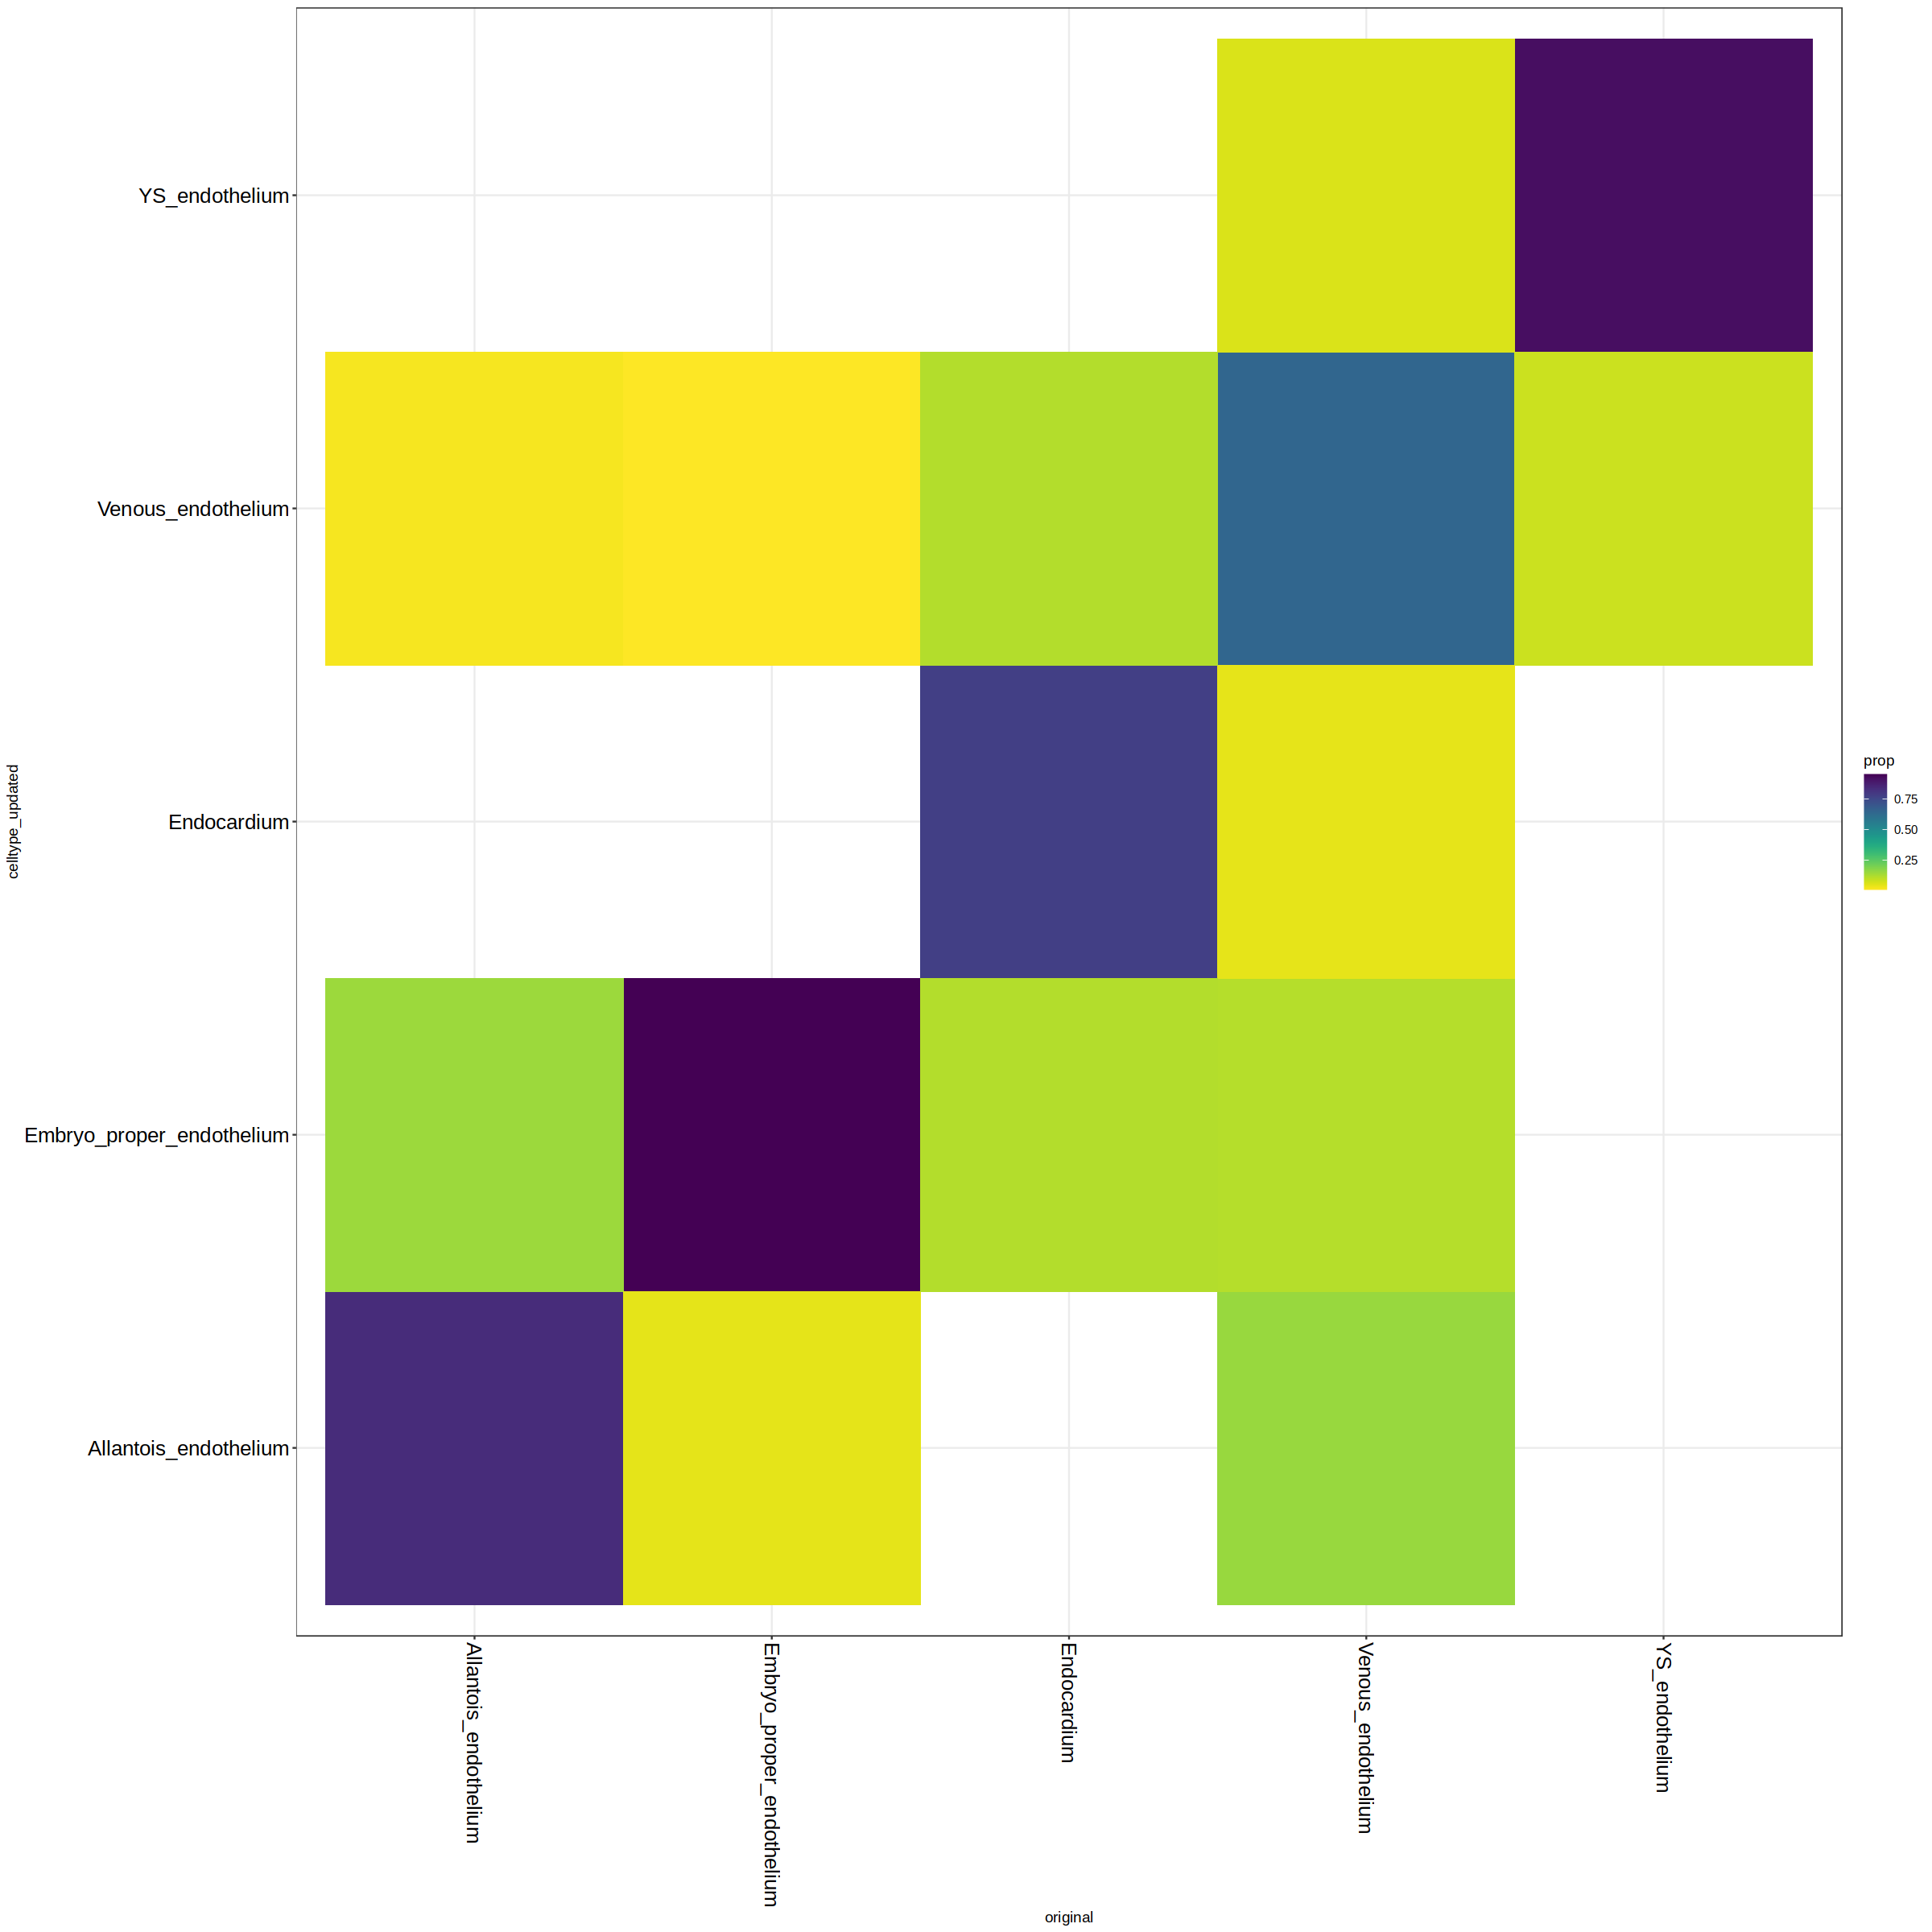

In [189]:
compare = data.table(cell = meta_full$cell, original = meta_full$celltype_extended.mapped_mnn, celltype_updated = meta_full$celltype_extended.mapped) %>%
    .[,count := .N, by=c('original', 'celltype_updated')] %>%
    .[,tot := .N, by='original'] %>% .[,prop := count/tot] %>%
    unique(by=c('original', 'celltype_updated')) 

options(repr.plot.width=20, repr.plot.height=20)
ggplot(compare[!is.na(original)], aes(original, celltype_updated, fill=prop)) + 
    geom_tile() + 
    viridis::scale_fill_viridis(begin=1, end=0) + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle=-90, hjust=0, vjust=0.5),
          axis.text = element_text(color='black', size=15))

In [190]:
mapping  <- mapWrap(
      sce_atlas = sce_atlas,
      meta_atlas = meta_atlas,
      sce_query = sce_query,
      meta_query = meta_query,
      genes = genes_to_use,
      npcs = args$npcs,
      k = args$n_neighbours,
      cosineNorm = FALSE,
      order = NULL
)


Normalizing joint dataset using cosineNorm=FALSE...

Done


1500 Genes provided...

Performing PCA...

Done


Batch effect correction for the atlas...

Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Done


MNN mapping...

Done


Computing mapping scores...

Done


Writing output...

Done




In [191]:
PCA = rbind(mapping$pca_atlas_corrected, mapping$pca_query_corrected)

In [192]:
meta_big = rbind(meta_atlas[,c('cell', 'celltype', 'celltype_extended')] %>% .[,origin:='atlas'],
                 mapping_endo[,c('cell', 'celltype.mapped', 'celltype_extended.mapped')] %>% 
                setnames(c('cell', 'celltype', 'celltype_extended'))  %>% .[,origin:='chimera']) %>%
    .[match(rownames(PCA), cell)]

In [193]:
UMAP <- as.data.table(calculateUMAP(t(PCA), n_neighbors = 25, min_dist = 0.3)) %>%
    setnames(c('UMAP1', 'UMAP2')) %>% 
    .[,cell:=rownames(PCA)] %>% 
    merge(., meta_big, by='cell')

In [194]:
options(repr.plot.width=15, repr.plot.height=6)
p1 = ggplot(UMAP, aes(UMAP1, UMAP2, color=origin)) + 
    geom_point(size=0.5) + 
 #   scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='none',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

options(repr.plot.width=15, repr.plot.height=6)
p2 = ggplot(UMAP, aes(UMAP1, UMAP2, color=celltype_extended)) + 
    geom_point(size=0.5) + 
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='right',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

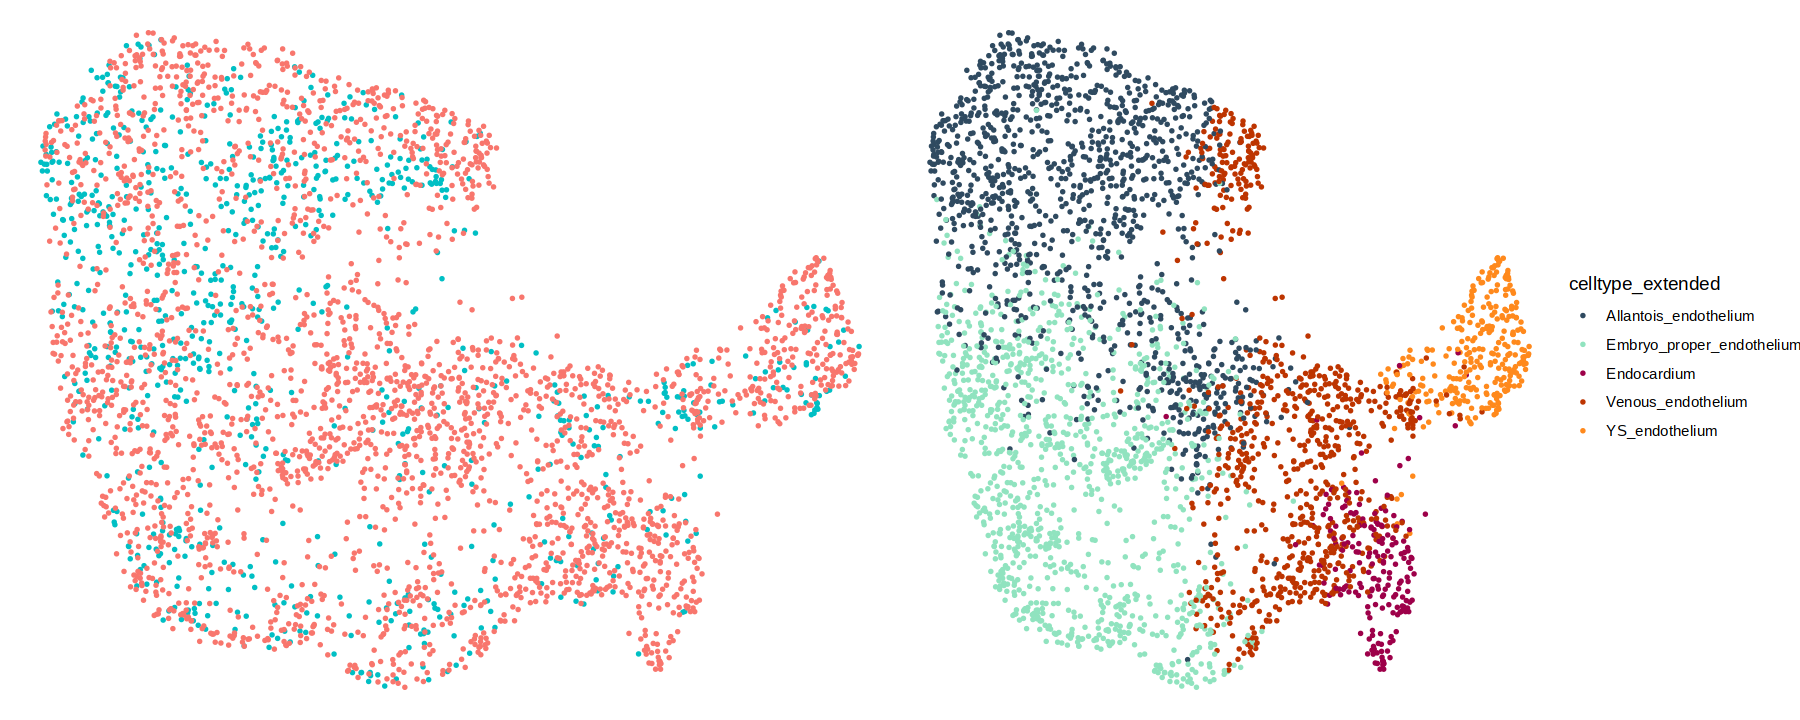

In [196]:
ggarrange(p1, p2)

In [199]:
UMAP_full = fread(file.path(paste0(io$basedir,"/results/rna/MiloR/manual/"), 'UMAP.txt.gz'))

In [201]:
test = merge(UMAP, UMAP_full, by='cell')

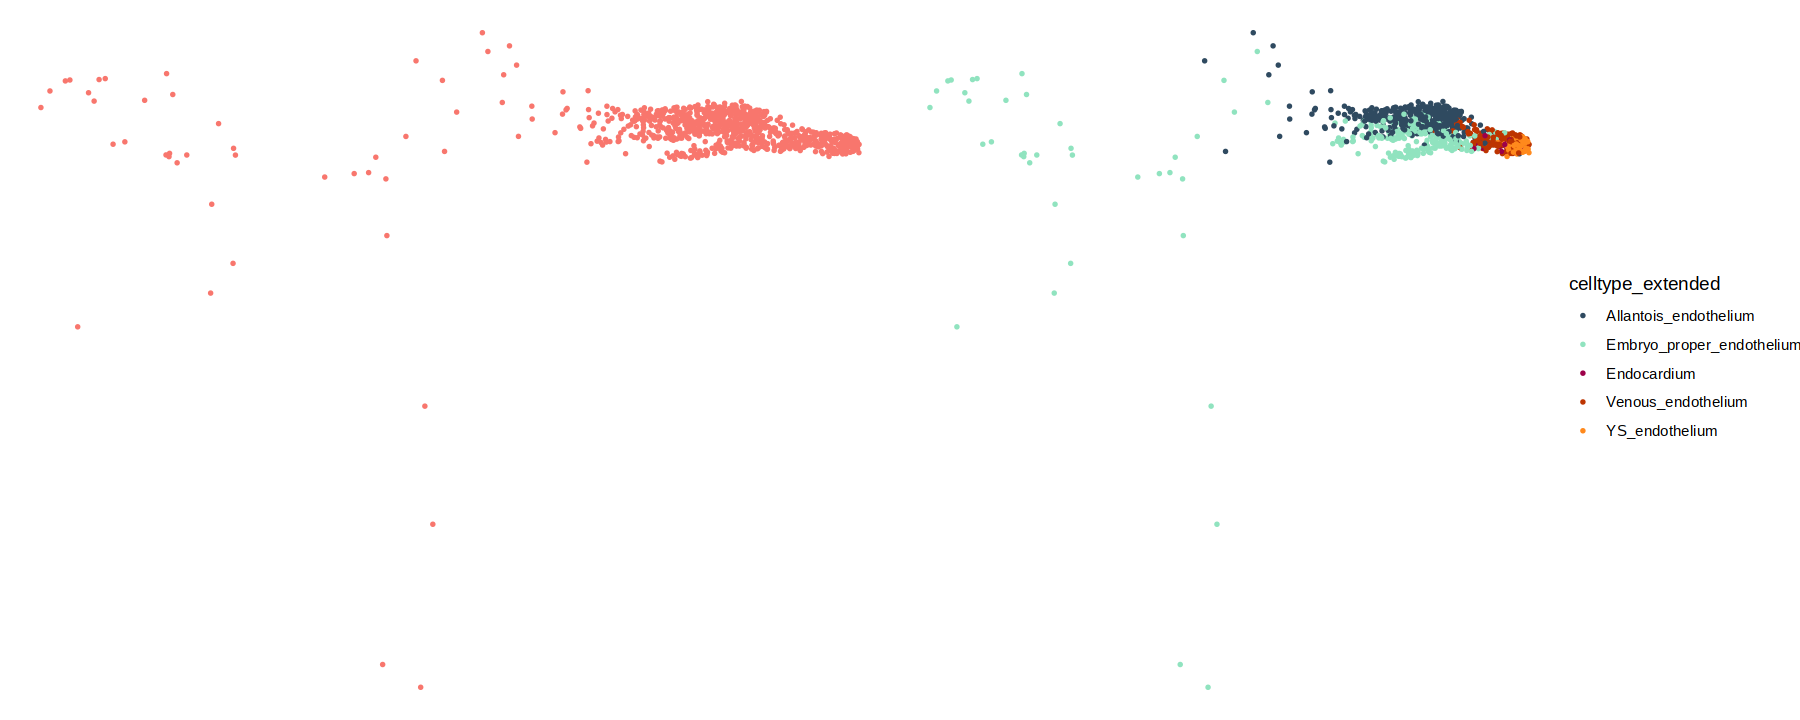

In [205]:
options(repr.plot.width=15, repr.plot.height=6)
p1 = ggplot(test, aes(UMAP1.y, UMAP2.y, color=origin)) + 
    geom_point(size=0.5) + 
 #   scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='none',
          strip.background=element_blank(),
          strip.text=element_text(size=20))

options(repr.plot.width=15, repr.plot.height=6)
p2 = ggplot(test, aes(UMAP1.y, UMAP2.y, color=celltype_extended)) + 
    geom_point(size=0.5) + 
    scale_color_manual(values=c(opts$celltype.colors, opts$celltype_extended.colors)) + 
    theme_void() + 
    theme(legend.position='right',
          strip.background=element_blank(),
          strip.text=element_text(size=20))
ggarrange(p1, p2)

In [209]:
test = merge(test, meta_query, by='cell')

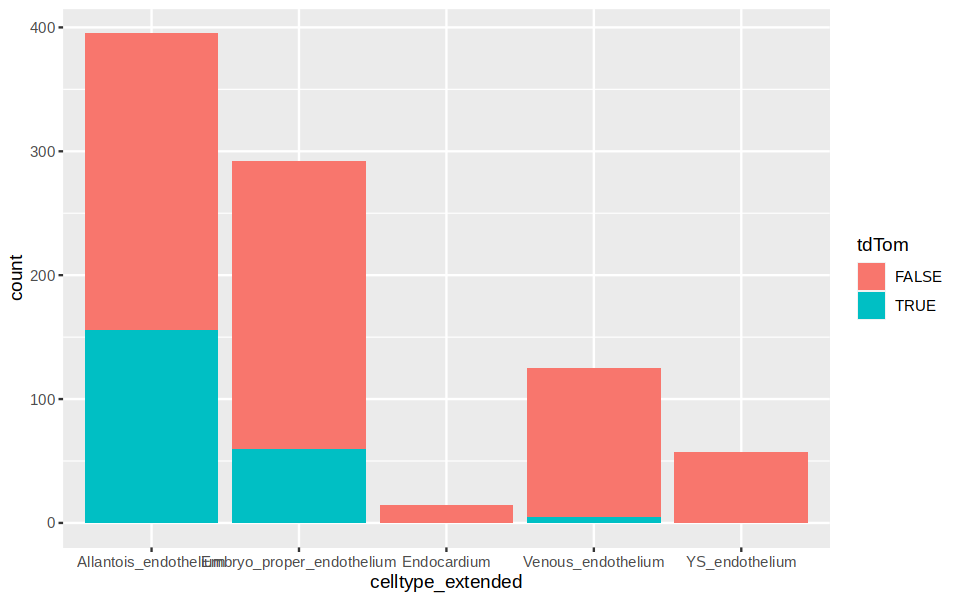

In [211]:
options(repr.plot.width = 8, repr.plot.height=5)

ggplot(test, aes(celltype_extended)) + 
    geom_bar(aes(fill=tdTom))